# Single-cell Data Preparation and Preprocessing #

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import STED

/home/lyx/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [ ]:
data_dir = './demo/PBMC'
out_dir = './demo/PBMC/test_CorEx'
sc_count_file = os.path.join(data_dir,"10k_PBMC_Multiome_RNA_counts.h5ad")
sc_anno_file = os.path.join(data_dir,"MainCelltype.txt")

seed = 1
ntopics = 10

In [3]:
if not os.path.exists(out_dir):
        os.makedirs(out_dir)

Create an scPreProcessing object to preprocess single-cell data. The sc_count_file parameter accepts both scRNA-Seq and single-cell epigenomic datasets.

In [4]:
scp = scPreProcessing()
scp.set_data(sc_count_file=sc_count_file,sc_anno_file=sc_anno_file)

In [5]:
scp.cell_selection()

The **gene_use** parameter defines the gene selection strategy. Options include 'All', 'MARKER', and 'HVG' (default is 'HVG'). <br>
<br>
When using the 'MARKER' method, the number of top marker genes is specified by ntopMarker (default: 200). For the 'HVG' method, the number of highly variable genes is controlled by ntopHvg (default: 500). <br>
<br>
If a **save_path** is provided, the list of selected genes will be saved to that directory. Additionally, gene_use accepts a list object to directly specify custom genes for downstream analysis.

In [6]:
# scp.geneWords(sc_anno_file, gene_use='HVG',save_path=out_dir)
gene_use = pd.read_csv(os.path.join(data_dir,"use_gene.csv"),index_col=0)['0'].to_list()
scp.geneWords(sc_anno_file, gene_use=gene_use)

# Topic Extraction with scTopic #

In [7]:
# Parameter Configuration for Data Preprocessing using the STED-CorEx Model
scp.preprocessing(linear2log=True)

# Parameter Configuration for Data Preprocessing using the STED-LDA Model
# scp.preprocessing(linear2log=False)

**anchored_genes** supports nested lists, where each sublist contains the anchor genes for a specific topic.

In [8]:
# anchor_words = []# Unsupervised
anchor_words = [
    ["CD79A", "MS4A1"],
    ["GNLY", "NKG7"],
    ["CCL5", "GZMK"],
   ["IL7R", "RORA","TCF7", "LEF1"],
   ["FCGR3A", "MS4A7", "LYZ", "CD14"],
   ["FCER1A", "CST3"]
]

In [9]:
scp.preForGuide(anchored_genes=anchor_words)

--- reflect genes in expression ---
6 anchored topics
16 genes were registered
--- extract cell type specific anchors ---
6 cells
set() type of anchored genes were removed (no specific after removing overlap)
16 genes were registered
seed number: 16
seed_k: 16
done.


Construct a scTopic object for model training.

In [10]:
sct = scTopic()
sct.setData(scp,out_dir)

Configure the **hierarchy_topic** parameter to guide the hierarchical modeling process.<br> 
<br>
For instance, when ntopics is set to 10 and hierarchy_topic is [6,2], the first CorEx iteration generates 10 topics, the second iteration builds upon these 10 topics to generate 6 new topics, and the third iteration further constructs 2 broader topics based on the 6 topics. <br>
<br>
When **tc_plot** is set to True, the resulting plots will be saved in the out_dir/model/ directory.

In [11]:
sct.trainCorEx(seed=seed,n_iter=200,n_ensemble=0,ntopics=ntopics,
               anchor_strength=2,hierarchy_topic = [6,2],tc_plot=True)

Selecting the Anchored CorEx model.
weight threshold is 0.000000 for graph with max of 72.000000 edges 


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Alternatively, hierarchical clustering is used to visualize the topic relationships obtained by the STED-CorEx model.


In [12]:
ht = sct.model.hierarchy(n_hidden_list=[6,2],max_edges=200,plot =True,figfile=None)

weight threshold is 0.000000 for graph with max of 72.000000 edges 


In [13]:
fig = sct.model.plot_hierarchy(ht)

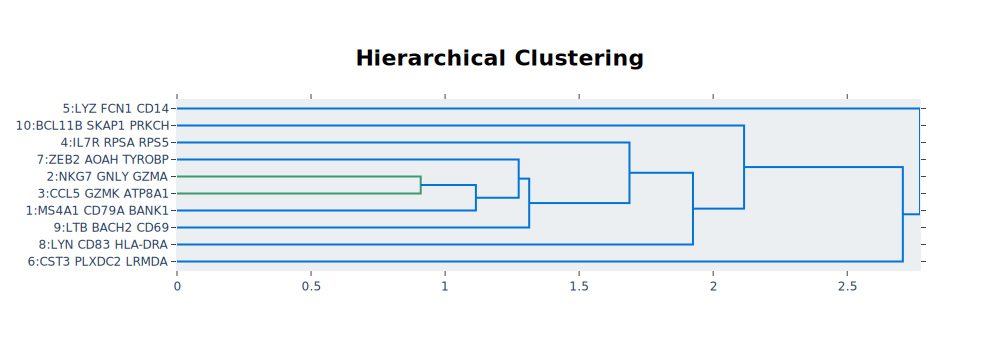

In [14]:
import plotly.io as pio
pio.renderers.default = "svg"
fig.show()

In [11]:
sct.trainLDA(seed=9, n_iter=200,n_ensemble=0,ntopics=ntopics,
            alpha=None,eta=None, # 默认为1/ntopics
            refresh=30,seed_confidence=0.15,ll_plot=True)

INFO:lda:n_documents: 9910
INFO:lda:vocab_size: 1531
INFO:lda:n_words: 308277
INFO:lda:n_topics: 10
INFO:lda:n_iter: 200


Selecting the Anchored LDA model.
Number of topics: 10
n_topics=10, n_iter=200, alpha=0.1,eta=0.1,random_state=9, refresh=30
seed_topics={1412: 0, 1087: 0, 283: 1, 1425: 1, 1322: 2, 640: 2, 632: 3, 579: 3, 1270: 3, 686: 3, 694: 4, 152: 4, 1180: 4, 1086: 4, 1449: 5, 145: 5}, seed_confidence=0.15
deconv_df.shape=(9910, 1531)
(9910, 1531)


INFO:lda:<0> log likelihood: -1999309
INFO:lda:<30> log likelihood: -1200556
INFO:lda:<60> log likelihood: -1181604
INFO:lda:<90> log likelihood: -1179109
INFO:lda:<120> log likelihood: -1175993
INFO:lda:<150> log likelihood: -1174819
INFO:lda:<180> log likelihood: -1174626
INFO:lda:<199> log likelihood: -1173867


Alternatively, hierarchical clustering can be applied to visualize the relationships among topics generated by the STED-LDA model.

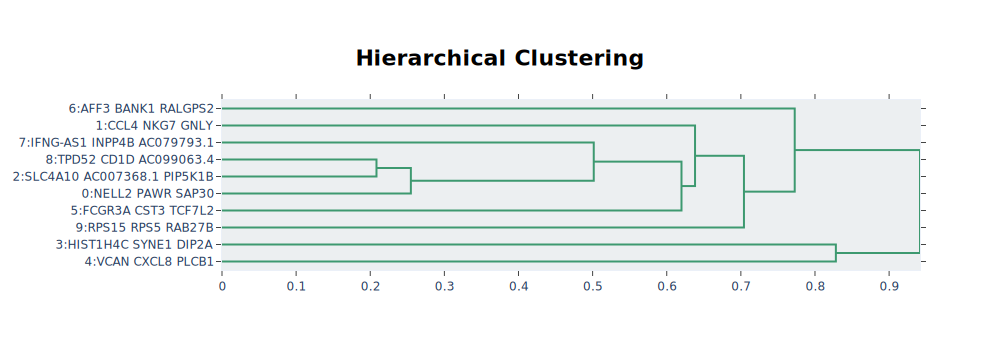

In [27]:
import plotly.io as pio
import plotly.graph_objs as go
pio.renderers.default = "svg"
fig = sct.model.plot_hierarchy()
fig.show()

Annotate single-cell topic models biologically (GO enrichment) and generate plots.
Since a topic often contains several gene sub-clusters, **TopicAnnotation** selects the most significant ones and maps the topic to specific cell types using the Cell Type Probability matrix. It then extracts high-weight genes for each topic to perform enrichment analysis and visualization.

In [ ]:
import os
import pkg_resources

r_script_path = pkg_resources.resource_filename('STED', 'R/TopicAnnotation.R')
cmd = f'Rscript "{r_script_path}" -i "{out_dir}" -g human -s "{seed}"'
os.system(cmd)

# or just run
# !Rscript ./R/TopicAnnotation.R -i "{out_dir}" -g human -s "{seed}"

# Bulk File Preparation and Preprocessing #

In [30]:
data_dir = './demo/PBMC'
out_dir = './demo/PBMC/test_CorEx'
gs_count_file = os.path.join(data_dir,"peaks_GAS.txt")
peak_count_file = os.path.join(data_dir,"peaks_counts.h5ad")

First, preprocess the single-cell data as before.

In [31]:
scp = scPreProcessing()
scp.set_data(sc_count_file=sc_count_file,sc_anno_file=sc_anno_file)
scp.cell_selection()
gene_use = pd.read_csv(os.path.join(data_dir,"use_gene.csv"),index_col=0)['0'].to_list()
scp.geneWords(sc_anno_file, gene_use=gene_use)

In [32]:
epid = gsPreProcessing()

The **gs_count_file** can be either bulk RNA-Seq count data or Gene Activity Scores (GAS) derived from epigenomic data.<br>
<br>
If using epigenomic data, please set **Epi=True**.<br>
When Epi=True, if gs_count_file is set to None by default, the gsPreProcessing function will automatically calculate the **Gene Activity Scores (GAS)** based on the peak_count_file. Alternatively, you may input a pre-calculated GAS file, as the GAS computation can be time-consuming.<br>
<br>
The **peak_count_file** is a read count file for peaks generated by tools such as featureCounts, supporting both BED and H5AD formats.<br>
<br>
Since **gene annotation (gene_anno_file)** is required for GAS calculation, it defaults to the hg38 genome assembly if set to None. For other species, please provide a corresponding gene annotation file.

In [33]:
# Epigenomic Deconvolution Input
# epid.set_data(Epi=True,peak_file=peak_count_file,gene_anno_file=gene_anno_file) #自动计算GAS
epid.set_data(Epi=True,peak_file=peak_count_file,gs_count_file=gs_count_file) #输入计算好的GAS
# RNA Deconvolution Input
# epid.set_data(Epi=False,gs_count_file=gs_count_file) #输入bulk RNA-seq counts

Only calculate for genes present in scTopic.

In [34]:
epid.gene_selection(scp.use_genes)

In [35]:
# Parameter Configuration for Data Preprocessing using the STED-CorEx Model
epid.preprocessing(linear2log=True)

# Parameter Configuration for Data Preprocessing using the STED-LDA Model
# epid.preprocessing(linear2log=False)

count_per_cell shape: (1,)


Note: Filter out genes that have no signal in bulk samples before performing deconvolution.

In [36]:
scp.geneShared(epid.gs_genes)

Subsequently, construct the scTopic object for model training.

In [37]:
scp.preprocessing(linear2log=True)
scp.preForGuide(anchored_genes=anchor_words)

sct = scTopic()
sct.setData(scp,out_dir)
# 如果重点是做反卷积任务，我们推荐设置高一点的topic number，此处由于PBMC细胞类型少，只有6种，我们以15例子
ntopics = 15
sct.trainCorEx(seed=seed,n_iter=200,n_ensemble=0,ntopics=ntopics,
               anchor_strength=2,hierarchy_topic = [6,2],tc_plot=True)

--- reflect genes in expression ---
6 anchored topics
16 genes were registered
--- extract cell type specific anchors ---
6 cells
set() type of anchored genes were removed (no specific after removing overlap)
16 genes were registered
seed number: 16
seed_k: 16
done.
Selecting the Anchored CorEx model.
weight threshold is 0.000000 for graph with max of 102.000000 edges 


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Next, create a scTopic object to be used for model training.

# Cell proportion and epigenetic signal estimation via scTopic + epiDecon #

Construct an epiDecon object for deconvolution and signal prediction. The out_dir parameter specifies the output directory for saving results and requires gsPreProcessing objects for both the preprocessed single-cell data and bulk data.

In [38]:
epi = epiDecon()
epi.SetData(out_dir,scp,epid)

The model parameter accepts a pre-trained scTopic model. If no model is provided (model=None), epiDecon will automatically search for the necessary files within the specified out_dir path.<br>
<br>
Setting **benchmark=True** instructs epiDecon to save intermediate files generated during the deconvolution process.
If a model is specified, epiDecon will automatically adopt the optimal normalization method selected during the scTopic training phase. <br>
<br>
Conversely, if model=None, you must manually specify the normalization method for the topic-celltype correlation matrix. Supported methods include: "Raw", "Norm", "NormBySD", "Bayes", and "BayesNorm" (default).

**Raw**: Utilizes the original topic_celltype weights directly for calculation without any transformation.<br>
<br>
**Norm**: Applies column-wise sum normalization (Sum-Norm) to the original weights. This normalizes the weights of cell types under each topic to sum to one, effectively treating them as a probability distribution (i.e., the probability of being a specific cell type given that topic).<br>
<br>
**NormBySD**: Scales the weights using StandardScaler (with_mean=False). This rescales the weights by the standard deviation to eliminate differences in numerical magnitude across topics, without removing the mean.<br>
<br>
**Bayes**: Uses the celltype_topic_mat_bayes.txt matrix file generated via the Bayesian method, with no additional processing applied.<br>
<br>
**BayesNorm**: Uses the celltype_topic_mat_bayes.txt matrix file generated via the Bayesian method, followed by column normalization (ensuring the weights for each topic sum to one).

In [39]:
epi.Decon(ntopics_selection=ntopics,seed_selection=seed,
          model=sct,model_selection="CorEx",#"LDA","ALDA"(guided LDA)
          outname=None,benchmark=False)
epi.Bayes()

The predicted cell proportions are stored in the celltype_frac_df attribute of the gsPreProcessing object.

In [40]:
epi.celltype_frac_df

,B cells,CD4 T cells,CD8 T cells,Dendritic cells,Monocytes,NK cells
Bulk,0.044902,0.440934,0.198553,0.016285,0.245627,0.053699


If you need to predict epigenetic signals for each cell type, run the **PeakPredict** function, inputting the single-cell data and the bulk sample preprocessing object.<br>
It supports directly reading the **gene2peak_project_mat** saved during GAS calculation.<br>
If **GS_file** is set to None, epiDecon will automatically recalculate it; in this case, the gene_anno_file is required (can be ignored for human samples).

In [41]:
GS_file = os.path.join(data_dir,"gene2peak_project_mat.h5ad")

In [42]:
predicted = epi.PeakPredict(sc_count_file,
                            epid,
                            GS_file=GS_file,
                            gene_anno_file=None)

/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



read gene peak weight matrix
default peak name


In [43]:
predicted

,chr1_865422_866353,chr1_869477_870378,chr1_876272_877037,chr1_877185_877929,chr1_896976_897832,chr1_898268_899165,chr1_904364_905213,chr1_910075_910856,chr1_920762_921638,chr1_923415_924300,...,chrX_154457667_154458606,chrX_154478633_154479530,chrX_154484222_154485044,chrX_154486250_154487107,chrX_154490305_154491211,chrX_154497366_154498281,chrX_155242134_155243020,chrX_155262680_155263367,chrX_155263990_155264871,chrX_155334535_155335348
NK cells,16.081331,399.625369,9.115621,9.287613,10.147578,23.133037,327.560368,24.680973,81.782597,170.874889,...,244.600655,376.397902,12.475953,171.184470,332.492145,7.197665,0.000000,0.000000,0.000000,0.000000
CD4 T cells,60.837581,1511.830164,34.485474,35.136143,38.389490,87.515023,1239.199719,93.371047,309.393261,646.439969,...,3541.783468,5450.189274,180.650064,2478.727322,4814.440010,104.221191,15.461649,5.322426,55.592745,8.223149
Monocytes,70.375059,1748.839024,39.891744,40.644419,44.407791,101.234710,1433.468440,108.008780,357.896688,747.782040,...,923.317229,1420.824763,47.094160,646.186212,1255.089547,27.169708,122.744066,42.252691,441.329353,65.280407
CD8 T cells,47.829311,1188.571176,27.111802,27.623346,30.181063,68.802592,974.234476,73.406483,243.238904,508.218405,...,1406.360462,2164.144357,71.731971,984.245405,1911.702999,41.383829,15.757317,5.424206,56.655827,8.380398
B cells,3.367706,83.688398,1.908967,1.944985,2.125077,4.844454,68.596753,5.168619,17.126677,35.784129,...,269.406970,414.570510,13.741209,188.545241,366.212025,7.927621,4.992693,1.718655,17.951352,2.655322
Dendritic cells,1.337845,33.245806,0.758351,0.772659,0.844202,1.924494,27.250544,2.053270,6.803693,14.215498,...,118.431325,182.245228,6.040636,82.884502,160.986834,3.484983,44.956669,15.475618,161.642825,23.909829
